<a href="https://colab.research.google.com/github/coolkite/machine_translation/blob/main/English%20To%20Spanish/%20English%20To%20Spanish%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2023-04-01 19:07:24--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5357029 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.11M  27.4MB/s    in 0.2s    

2023-04-01 19:07:24 (27.4 MB/s) - ‘spa-eng.zip’ saved [5357029/5357029]



In [12]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip

--2023-04-01 19:14:47--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 52.22.128.237, 34.206.0.154, 54.82.45.103, ...
Connecting to huggingface.co (huggingface.co)|52.22.128.237|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.42B.300d.zip%3B+filename%3D%22glove.42B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1680635688&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzM1N2JhYWMzMzA5MGY2NDVlNzFlMjUzYjMyOTVlZTFiNzY3Yzk4YTAzMzZlOWExZDk5Yzc3ZTllMzNiNDNjNGE%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNjgwNjM1Njg4fX19XX0_&Signature=LJYMQi6

In [3]:
!unzip "/content/spa-eng.zip"

Archive:  /content/spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [13]:
!unzip "/content/glove.42B.300d.zip"

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing import *
from keras.models import Model
from keras.layers import *
from keras.utils import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.21.64.154:8470


REPLICAS:  8


In [7]:
df = pd.read_csv("/content/spa.txt", sep='\t')

encoder_train = df.iloc[:,0].to_numpy()
decoder_train = df.iloc[:,1].to_numpy()
print(encoder_train.shape, decoder_train.shape)
print(encoder_train[11])
print(decoder_train[11])

(139635,) (139635,)
Who?
¿Quién?


In [9]:
def tokenize(dataset):
  dataset = ["<BOS> " + train + " <EOS>" for train in dataset]
  token = text.Tokenizer(num_words = None)
  token.fit_on_texts(dataset)
  dataset = token.texts_to_sequences(dataset)
  return dataset, token.word_index

def padding(dataset):
  max_length = max([len(text) for text in dataset])
  dataset = pad_sequences(dataset, maxlen=max_length, padding = 'post', truncating = 'post')
  return max_length, dataset

In [10]:
import pickle

encoder_train, enc_dict = tokenize(encoder_train)
decoder_train, dec_dict = tokenize(decoder_train)
print(encoder_train[11])

max_enc_seq_length, enc_train_pad = padding(encoder_train)
max_dec_seq_length, dec_train_pad = padding(decoder_train)
print(enc_train_pad[11])
print(max_enc_seq_length)
print(dec_train_pad[11])
print(max_dec_seq_length)

print(enc_dict)

with open('engTokenizer.pickle', 'wb') as handle:
    pickle.dump(enc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('spaTokenizer.pickle', 'wb') as handle:
    pickle.dump(dec_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print()

[1, 81, 2]
[ 1 81  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
72
[  1 138   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
70
{'bos': 1, 'eos': 2, 'i': 3, 'the': 4, 'to': 5, 'you': 6, 'tom': 7, 'a': 8, 'is': 9, 'he': 10, 'in': 11, 'that': 12, 'of': 13, 'it': 14, 'do': 15, 'was': 16, 'me': 17, 'this': 18, 'have': 19, 'my': 20, "don't": 21, 'for': 22, 'are': 23, 'what': 24, 'your': 25, 'we': 26, 'she': 27, "i'm": 28, 'mary': 29, 'be': 30, 'his': 31, 'on': 32, 'want': 33, 'with': 34, 'not': 35, 'like': 36, 'and': 37, 'know': 38, 'at': 39, 'can': 40, 'go': 41, 'him': 42, "it's": 43, 'has': 44, 'how': 

In [14]:
embeddings_index = {}
f = open('/content/glove.42B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

1917495it [02:40, 11965.12it/s]


In [15]:
def Glove(latentDim, dictionary):
  embedding_matrix = np.zeros((len(dictionary) + 1, latentDim))
  for word, i in tqdm(dictionary.items()):
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  
  return embedding_matrix


100%|██████████| 28962/28962 [00:00<00:00, 141718.34it/s]


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 72)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 72, 300)      4289400     ['input_14[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 gru_21 (GRU)                   [(None, 72, 300),    541800      ['embedding_13[0][0]']           
                                 (None, 300)]                                               

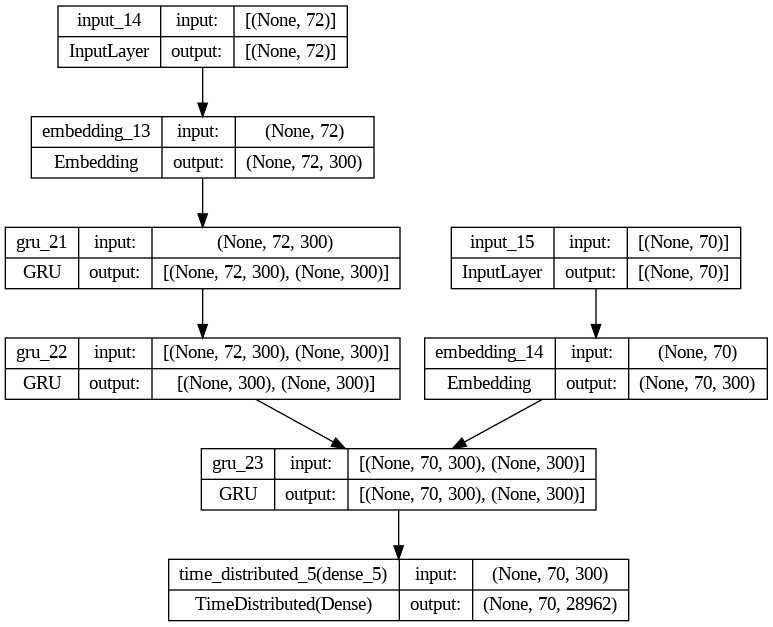

In [29]:
latentDim = 300
UNIQUE_ENC_WORDS = len(enc_dict)
UNIQUE_DEC_WORDS = len(dec_dict)

with strategy.scope():
  encoder_input = Input(shape=(max_enc_seq_length,))
  mid_encoder_layer = GRU(latentDim, return_sequences = True, return_state=True)
  final_encoder_layer = GRU(latentDim, return_state=True)
  encoder_embed = Embedding(UNIQUE_ENC_WORDS+1, latentDim, weights = [Glove(latentDim, enc_dict)], input_length=max_enc_seq_length, trainable = False)(encoder_input)
  encoder_1 = mid_encoder_layer(encoder_embed)
  encoder_output, encoder_hidden = final_encoder_layer(encoder_1)

  decoder_input = Input(shape = (max_dec_seq_length,))
  decoder_embed = Embedding(UNIQUE_DEC_WORDS+1, latentDim, weights = [Glove(latentDim, dec_dict)], input_length=max_dec_seq_length, trainable = False)(decoder_input)
  decoder_layer = GRU(latentDim, return_sequences=True, return_state=True)
  #decoder_1 = mid_dec_layer(decoder_embed, initial_state = encoder_hidden)
  decoder_output, _ = decoder_layer(decoder_embed, initial_state = encoder_hidden)

  output_layer = TimeDistributed(Dense(UNIQUE_DEC_WORDS, activation="softmax"))(decoder_output)

  model = Model([encoder_input, decoder_input], output_layer)
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

plot_model(model, to_file='model.png', show_shapes=True)


In [30]:
decoder_target = [np.append(arr[1:],0) for arr in dec_train_pad]
decoder_target = np.array(decoder_target)

In [31]:
print(enc_train_pad.shape, dec_train_pad.shape, decoder_target.shape)
print(enc_train_pad[137859], dec_train_pad[137859], decoder_target[137859])

(139635, 72) (139635, 70) (139635, 70)
[   1    7 1243   12    4 1405  199    5  726    4  349   57 2505    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] [   1    6  507    4    9 1546  106 2392    8  142  310    3   19 3369
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0] [   6  507    4    9 1546  106 2392    8  142  310    3   19 3369    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0

In [32]:
history = model.fit([enc_train_pad, dec_train_pad], 
                    decoder_target, 
                    batch_size = 128*strategy.num_replicas_in_sync,
                    epochs = 20,
                    validation_split = 0.3,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
                    shuffle = True
                    )

Epoch 1/20
96/96 [==============================] - 54s 399ms/step - loss: 1.3577 - accuracy: 0.9210 - val_loss: nan - val_accuracy: 0.8755
Epoch 2/20
96/96 [==============================] - 24s 247ms/step - loss: 0.4814 - accuracy: 0.9338 - val_loss: nan - val_accuracy: 0.8774
Epoch 3/20
96/96 [==============================] - 24s 248ms/step - loss: 0.4550 - accuracy: 0.9351 - val_loss: nan - val_accuracy: 0.8790
Epoch 4/20
96/96 [==============================] - 24s 248ms/step - loss: 0.4359 - accuracy: 0.9363 - val_loss: nan - val_accuracy: 0.8820
Epoch 5/20
96/96 [==============================] - 24s 249ms/step - loss: 0.3904 - accuracy: 0.9410 - val_loss: nan - val_accuracy: 0.8905
Epoch 6/20
96/96 [==============================] - 24s 250ms/step - loss: 0.3257 - accuracy: 0.9485 - val_loss: nan - val_accuracy: 0.8974
Epoch 7/20
96/96 [==============================] - 24s 248ms/step - loss: 0.2738 - accuracy: 0.9538 - val_loss: nan - val_accuracy: 0.9020
Epoch 8/20
96/96 [==

In [33]:
model.save("engToSpaFin.h5")